In [ ]:
#import Libraries
import numpy as np
import pandas as pd
import os
import random
import itertools
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img,img_to_array

from keras.utils import np_utils
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Reshape, Dropout
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping



from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [ ]:
#dataset implementation
img_size = 224
df_data = pd.read_csv('/content/full_df.csv')
df_data.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [ ]:
#dropping of columns
df_data2 = df_data.iloc[:, 1:7]
df_data2.head()

,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords
0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus
1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus
2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy
3,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy
4,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy


In [ ]:
#gathering of data from selected Parameters
img_dir =('/content/Images')
df_left_cat = df_data2[df_data2['Left-Diagnostic Keywords'].str.match('cataract')]
print(len(df_left_cat))
df_rt_cat = df_data2[df_data2['Right-Diagnostic Keywords'].str.match('cataract')]
print(len(df_rt_cat))

294
278


In [ ]:
df_cat_filenames = df_left_cat['Left-Fundus'].append(df_rt_cat['Right-Fundus'], ignore_index=True)
df_cat_filenames.head()
df_cat_filenames.tail()
len(df_cat_filenames)

572

In [ ]:
df_left_norm = df_data2[df_data2['Left-Diagnostic Keywords'].str.match('normal')]
print(len(df_left_norm))
df_rt_norm = df_data2[df_data2['Right-Diagnostic Keywords'].str.match('normal')]
print(len(df_rt_norm))
df_norm_filenames = df_left_norm['Left-Fundus'].append(df_rt_norm['Right-Fundus'], ignore_index=True)
df_norm_filenames
len(df_norm_filenames)

2855
2735


5590

In [ ]:
df_left_glau = df_data2[df_data2['Left-Diagnostic Keywords'].str.match('glaucoma')]
print(len(df_left_glau))
df_rt_glau = df_data2[df_data2['Right-Diagnostic Keywords'].str.match('glaucoma')]
print(len(df_rt_glau))
df_glau_filenames = df_left_glau['Left-Fundus'].append(df_rt_glau['Right-Fundus'], ignore_index=True)
len(df_glau_filenames)

262
232


494

In [ ]:
df_left_hyper = df_data2[df_data2['Left-Diagnostic Keywords'].str.match('diabetic retinopathy')]
print(len(df_left_hyper))
df_rt_hyper = df_data2[df_data2['Right-Diagnostic Keywords'].str.match('diabetic retinopathy')]
print(len(df_rt_hyper))
df_hyper_filenames = df_left_hyper['Left-Fundus'].append(df_rt_hyper['Right-Fundus'], ignore_index=True)
df_hyper_filenames
len(df_hyper_filenames)

30
20


50

In [ ]:
df_norm_filenames_random = df_norm_filenames.sample(n = 572)
df_norm_filenames_random.head()
df_norm_filenames_random = df_norm_filenames_random.reset_index(drop=True)
df_norm_filenames_random

0       3281_left.jpg
1       2828_left.jpg
2       3347_left.jpg
3       2970_left.jpg
4      3160_right.jpg
            ...      
567     1060_left.jpg
568     2974_left.jpg
569    3309_right.jpg
570    2979_right.jpg
571    3444_right.jpg
Length: 572, dtype: object

In [ ]:
df_cat_filenames = pd.DataFrame(df_cat_filenames, columns = ["filename"])
df_cat_filenames["label"] = "cataract"
df_cat_filenames.head()

,filename,label
0,0_left.jpg,cataract
1,103_left.jpg,cataract
2,119_left.jpg,cataract
3,254_left.jpg,cataract
4,294_left.jpg,cataract


In [ ]:
df_norm_filenames_random = pd.DataFrame(df_norm_filenames_random, columns = ["filename"])
df_norm_filenames_random["label"] = "normal"
df_norm_filenames_random.head()

,filename,label
0,3281_left.jpg,normal
1,2828_left.jpg,normal
2,3347_left.jpg,normal
3,2970_left.jpg,normal
4,3160_right.jpg,normal


In [ ]:
df_glau_filenames= pd.DataFrame(df_hyper_filenames, columns = ["filename"])
df_glau_filenames["label"] = "Glaucoma"
df_glau_filenames.head()

,filename,label
0,64_left.jpg,Glaucoma
1,67_left.jpg,Glaucoma
2,71_left.jpg,Glaucoma
3,234_left.jpg,Glaucoma
4,311_left.jpg,Glaucoma


In [ ]:
df_hyper_filenames= pd.DataFrame(df_hyper_filenames, columns = ["filename"])
df_hyper_filenames["label"] = "Diabetes"
df_hyper_filenames.head()

,filename,label
0,64_left.jpg,Diabetes
1,67_left.jpg,Diabetes
2,71_left.jpg,Diabetes
3,234_left.jpg,Diabetes
4,311_left.jpg,Diabetes


In [ ]:
#combinig the data into a list
df_combined = df_cat_filenames.append(df_norm_filenames_random, ignore_index=True)
df_combined_2 = df_combined.append(df_glau_filenames, ignore_index=True)
df_combined_3 = df_combined_2.append(df_hyper_filenames, ignore_index=True)
df_combined_3

,filename,label
0,0_left.jpg,cataract
1,103_left.jpg,cataract
2,119_left.jpg,cataract
3,254_left.jpg,cataract
4,294_left.jpg,cataract
...,...,...
1239,978_right.jpg,Diabetes
1240,997_right.jpg,Diabetes
1241,1838_right.jpg,Diabetes
1242,1942_right.jpg,Diabetes


In [ ]:
#Final Dataset
df_combined_random = df_combined_3.sample(frac=1).reset_index(drop=True)
df_combined_random

,filename,label
0,2416_left.jpg,normal
1,938_right.jpg,Glaucoma
2,835_left.jpg,normal
3,2587_right.jpg,normal
4,3062_right.jpg,normal
...,...,...
1239,3116_left.jpg,normal
1240,27_left.jpg,normal
1241,1942_right.jpg,Glaucoma
1242,3448_left.jpg,normal


In [ ]:
#Training data
df_train = df_combined_random.sample(frac=0.9,random_state=42)
df_train.reset_index(drop=True)
df_test = df_combined_random.drop(df_train.index)
df_test.reset_index(drop=True)

print(len(df_combined_random))
print(len(df_train))
print(len(df_test))

1244
1120
124


In [ ]:
# data preprocessing
train_datagen=tf.keras.preprocessing.image.ImageDataGenerator(
            rescale=1./255.,
            validation_split=0.20,
            rotation_range=90,

            horizontal_flip=True,
            vertical_flip=True,
            shear_range=0.2,
            brightness_range=[0.3,1]

            )


test_datagen=ImageDataGenerator(rescale=1./255.)
df_train['label'] = df_train['label'].astype(str)
df_test['label'] = df_test['label'].astype(str)

In [ ]:
train_generator=train_datagen.flow_from_dataframe(
dataframe=df_train,
directory=img_dir,
x_col="filename",
y_col="label",
subset="training",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(img_size,img_size))
valid_generator=train_datagen.flow_from_dataframe(
dataframe=df_train,
directory=img_dir,
x_col="filename",
y_col="label",
subset="validation",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(img_size,img_size))



test_generator=test_datagen.flow_from_dataframe(
dataframe=df_test,
directory=img_dir,
x_col="filename",
y_col="label",
batch_size=10,

shuffle=False,
class_mode="categorical",
target_size=(img_size,img_size))

train_image_data, train_labels = train_generator.next()
train_image_data.shape

Found 254 validated image filenames belonging to 4 classes.
Found 63 validated image filenames belonging to 4 classes.
Found 24 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 803 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 100 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


(32, 224, 224, 3)

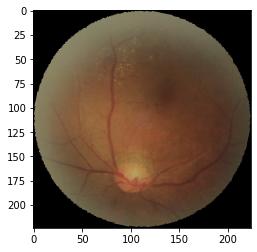

In [ ]:
train_labels[0]
plt.imshow(train_image_data[0], interpolation='nearest')
plt.show()

In [ ]:
#Model traning
vgg16 = keras.applications.vgg16.VGG16(input_shape=(224, 224, 3),
                                       weights='imagenet',
                                       include_top=False)


x = keras.layers.Flatten()(vgg16.output)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(128, activation='relu')(x)

predictions = keras.layers.Dense(4, activation='softmax')(x)

model = keras.Model(inputs=vgg16.inputs, outputs=predictions)
for layer in vgg16.layers:
    layer.trainable = False

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
checkpoint = ModelCheckpoint("vgg16_1.h5",
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False,
                             mode='auto',
                             period=1)

early = EarlyStopping(monitor='val_accuracy',
                      min_delta=0,
                      patience=3,
                      verbose=1,
                      mode='auto')

In [ ]:
batch_size = 32
n_spe = train_generator.samples // batch_size
n_val_steps = valid_generator.samples // batch_size
n_epochs = 30

print(n_spe,n_val_steps)

7 1


In [ ]:
#Epoch
hist = model.fit(train_generator,
                        steps_per_epoch=n_spe,
                        validation_data=valid_generator,
                        validation_steps=n_val_steps,
                        epochs=n_epochs,
                        shuffle=True,
                        workers=5,
                        use_multiprocessing=True,
                        callbacks=[checkpoint,early])

Epoch 1/30
7/7 [==============================] - ETA: 0s - loss: 0.2948 - accuracy: 0.7703
Epoch 1: val_accuracy did not improve from 0.90625
7/7 [==============================] - 11s 1s/step - loss: 0.2948 - accuracy: 0.7703 - val_loss: 0.2703 - val_accuracy: 0.6875
Epoch 2/30
7/7 [==============================] - ETA: 0s - loss: 0.2668 - accuracy: 0.7812
Epoch 2: val_accuracy did not improve from 0.90625
7/7 [==============================] - 10s 1s/step - loss: 0.2668 - accuracy: 0.7812 - val_loss: 0.2479 - val_accuracy: 0.7500
Epoch 3/30
7/7 [==============================] - ETA: 0s - loss: 0.2548 - accuracy: 0.8125
Epoch 3: val_accuracy did not improve from 0.90625
7/7 [==============================] - 11s 1s/step - loss: 0.2548 - accuracy: 0.8125 - val_loss: 0.1851 - val_accuracy: 0.8750
Epoch 4/30
7/7 [==============================] - ETA: 0s - loss: 0.2482 - accuracy: 0.8198
Epoch 4: val_accuracy did not improve from 0.90625
7/7 [==============================] - 15s 2s/s

In [ ]:
!pip install openpyxl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
